<a href="https://colab.research.google.com/github/zyberg2091/Real-or-Not-Disaster-Tweets/blob/master/Real_or_Not_NLP_with_Disaster_Tweets_with-and-without-bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#using EDA,BiLSTMs
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras.layers import Input,Dense,Dropout,Bidirectional,LSTM,Embedding,GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from wordcloud import WordCloud, STOPWORDS

In [ ]:
import csv
with open('/content/test.csv', 'r') as f:
  file=csv.reader(f)
  for row in file:
    print(row)
    break

['id', 'keyword', 'location', 'text']


In [ ]:
df=pd.read_csv("train.csv")
df1=pd.read_csv("test.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#find the the most common words in the tweets
#using wordcloud
stopwords = set(STOPWORDS)
def word_cloud(data,title=None):
    cloud = WordCloud(background_color = 'black',
                     stopwords = stopwords,
                     max_words = 200,
                     max_font_size = 40,
                     scale = 3).generate(str(data))
    fig = plt.figure(figsize=(15,15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.25)
        plt.imshow(cloud)
        plt.show()


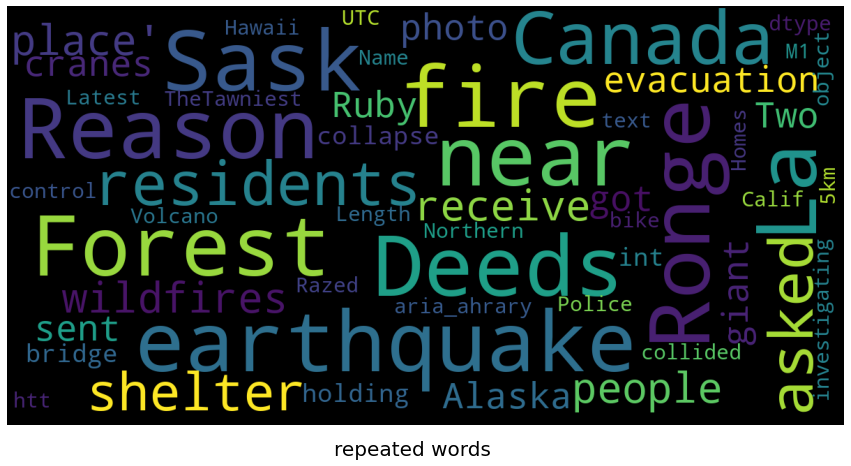

In [ ]:
word_cloud(df['text'],'repeated words')

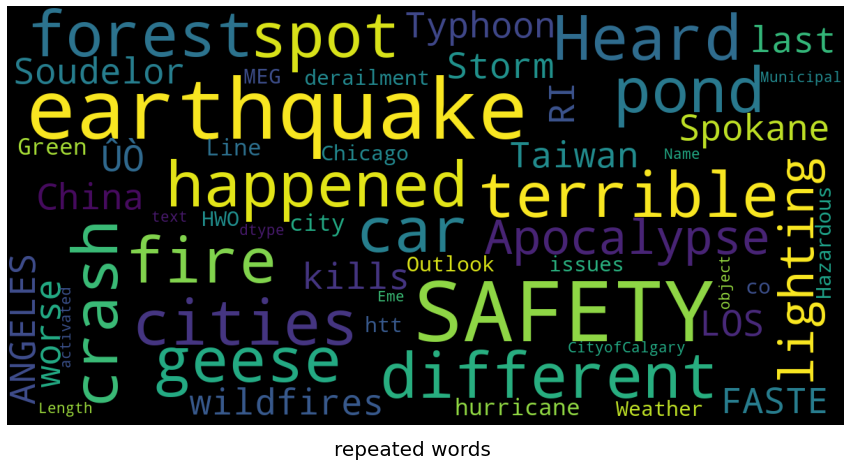

In [ ]:
word_cloud(df1['text'],'repeated words')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


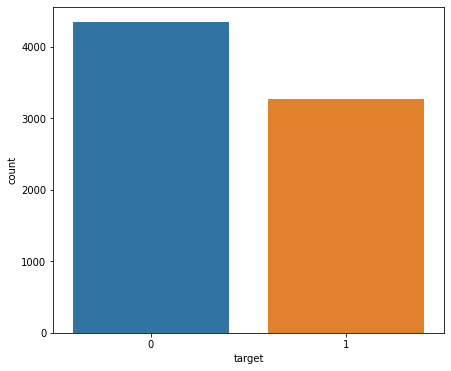

In [ ]:
import seaborn as sns
plt.figure(figsize=(7,6))
sns.countplot(df['target'])

In [ ]:
import re

In [ ]:
#data cleaning

def remove_emoji(text):
  emoji_pattern=re.compile("["
        u"\U0001F600-\U0001F64F"                             # emoticons
        u"\U0001F300-\U0001F5FF"                             # symbols & pictographs
        u"\U0001F680-\U0001F6FF"                             # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"                             # flags (iOS)
                           "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)                       # no emoji

In [ ]:
df['text']=df['text'].apply(lambda x:remove_emoji(x))
df1['text']=df1['text'].apply(lambda x:remove_emoji(x))

In [ ]:
def clean_text(data):
  data=re.sub(r'https?://\S+|www\.\S+',' ',data)
  t = [w for w in data.split() if w not in stopwords]
  data = ' '.join(t)
  data = data.lower()
  data = re.sub('[^a-zA-Z]',' ', data)

  return data

In [ ]:
df['text']=df['text'].apply(lambda x:clean_text(x))
df1['text']=df1['text'].apply(lambda x:clean_text(x))


In [ ]:
x_train=df.iloc[:,3].values
y_train=df.iloc[:,4].values

In [ ]:
x_train.shape

(7613,)

In [ ]:
x_train[:2],y_train[:2]

(array(['our deeds reason  earthquake may allah forgive us',
        'forest fire near la ronge sask  canada'], dtype=object),
 array([1, 1]))

In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(x_train)
sequences=tokenizer.texts_to_sequences(x_train)
word_index=tokenizer.word_index

In [ ]:
x_train[:2]

array(['our deeds reason  earthquake may allah forgive us',
       'forest fire near la ronge sask  canada'], dtype=object)

In [ ]:
a=[(i,value) for i,value in word_index.items()]
a[:10]

[('i', 1),
 ('s', 2),
 ('the', 3),
 ('a', 4),
 ('amp', 5),
 ('m', 6),
 ('will', 7),
 ('fire', 8),
 ('in', 9),
 ('it', 10)]

In [ ]:
sequences[:2]

[[561, 4387, 796, 195, 79, 1530, 4388, 32],
 [130, 8, 167, 668, 6493, 6494, 1138]]

In [ ]:
vocab_size=len(word_index)

In [ ]:
value=max([i for x in x_train for i in range(len(x.split()))])

In [ ]:
value

27

In [ ]:
x_pad=pad_sequences(sequences,maxlen=value,padding='post')


In [ ]:
y_train.shape

(7613,)

In [ ]:
T=x_pad.shape[1]

In [ ]:
#Glove embedding

!wget --no-check-certificate \https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
-O /tmp/glove.6B.100d.txt

embedding_dim=100

embedding_index={}
with open("/tmp/glove.6B.100d.txt") as f:
  for line in f:
    val=line.split()
    word=val[0]
    word_ind=np.asarray(val[1:],dtype='float32')
    embedding_index[word]=word_ind

embedding_matrix = np.zeros((vocab_size+1, embedding_dim))
for w,t in word_index.items():
  embedding_vector=embedding_index.get(w)
  if embedding_vector is not None:
    embedding_matrix[t]=embedding_vector




--2020-11-20 14:36:58--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 142.250.73.240, 172.217.13.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   181MB/s    in 1.8s    

2020-11-20 14:37:00 (181 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [ ]:
y_train

array([1, 1, 1, ..., 1, 1, 1])

# Bert Implementation in tensorflow 

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 14.5MB/s 
     |████████████████████████████████| 890kB 46.6MB/s 
     |████████████████████████████████| 1.1MB 44.3MB/s 
     |████████████████████████████████| 2.9MB 49.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=96d240baf2d104dc55cf9c386bd42d317483b9e44f6791b0211e5c4323423015
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
def tokenize_sentences(sentences, tokenizer, max_seq_len = 30):
    tokenized_sentences = []
    for sentence in sentences:
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len, 
                            truncation= True           # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

In [ ]:
def create_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)
    return np.asarray(attention_masks)


In [ ]:
from transformers import BertTokenizer, glue_convert_examples_to_features
from tokenizers import BertWordPieceTokenizer
import tensorflow as tf


In [ ]:
# tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
input_ids=tokenize_sentences(x_train,bert_tokenizer)
input_ids=pad_sequences(input_ids,maxlen=30,padding='post')

In [ ]:
attention_masks = create_masks(input_ids)

In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
input_ids[1],attention_masks[1]

(array([  101,  3224,  2543,  2379,  2474,  6902,  3351, 21871,  2243,
         2710,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0], dtype=int32),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
from sklearn.model_selection import train_test_split

labels=y_train
train_ids, validation_ids, train_labels, validation_labels = train_test_split(input_ids, labels , random_state=0, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=0, test_size=0.1)

train_size = len(train_ids)
validation_size = len(validation_ids)

In [ ]:
train_ids=tf.convert_to_tensor(train_ids)
train_masks=tf.convert_to_tensor(train_masks)
train_labels=tf.convert_to_tensor(train_labels)

validation_ids=tf.convert_to_tensor(validation_ids)
validation_masks=tf.convert_to_tensor(validation_masks)
validation_labels=tf.convert_to_tensor(validation_labels)


In [ ]:
train_labels=tf.one_hot(train_labels, 2)

In [ ]:
# train_ids=train_ids[:100]
# train_masks=train_masks[:100]
# train_labels=train_labels[:100]          

In [ ]:
train_ids,train_labels,train_masks

(<tf.Tensor: shape=(6851, 30), dtype=int32, numpy=
 array([[  101,  8116,  3643, ...,     0,     0,     0],
        [  101,  2660,  2739, ...,     0,     0,     0],
        [  101, 19031, 27983, ...,     0,     0,     0],
        ...,
        [  101,  2307,  2329, ...,     0,     0,     0],
        [  101,  2304,  3239, ...,     0,     0,     0],
        [  101,  3505, 19362, ...,     0,     0,     0]], dtype=int32)>,
 <tf.Tensor: shape=(6851, 2), dtype=float32, numpy=
 array([[0., 1.],
        [0., 1.],
        [1., 0.],
        ...,
        [0., 1.],
        [1., 0.],
        [1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(6851, 30), dtype=int64, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]])>)

In [ ]:
# def create_dataset(ids, masks, labels):
#     def gen():
#         for i in range(len(ids)):
#             yield (
#                 {
#                     "input_ids": ids[i],
#                     "attention_mask": masks[i]
#                 },
#                 labels[i],
#             )

#     return tf.data.Dataset.from_generator(
#         gen,
#         ({"input_ids": tf.int32, "attention_mask": tf.int64}, tf.int64),
#         (
#             {
#                 "input_ids": tf.TensorShape([100, 128]),
#                 "attention_mask": tf.TensorShape([100, 128]),
#             },
#             tf.TensorShape([100,]),
#         ),
#     )

In [ ]:
# train_dataset_tweets = create_dataset(train_ids, train_masks, train_labels)
# type(train_dataset_tweets)

In [ ]:
from transformers import TFBertForSequenceClassification, BertConfig, TFDistilBertForSequenceClassification, DistilBertConfig
#bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',config=BertConfig.from_pretrained('bert-base-uncased',num_labels=2))
bert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=DistilBertConfig(num_labels=2))
# X = tf.keras.layers.Dropout(0.2)(X)
# X = tf.keras.layers.Dense(6, activation='softmax')


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
AUTO=AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16
train_dataset=tf.data.Dataset.from_tensor_slices(((train_ids,train_masks),train_labels)).shuffle(100).prefetch(AUTO)
val_dataset=tf.data.Dataset.from_tensor_slices(((validation_ids,validation_masks),validation_labels)).cache().prefetch(AUTO)

In [ ]:
next(iter(train_dataset.batch(1)))

((<tf.Tensor: shape=(1, 30), dtype=int32, numpy=
  array([[  101,  2945,  9790,  8009, 20589,  2015,  2062,  2945,  5360,
          10611,  8293,  8009, 20589,  2015,  4487, 17310,   102,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0]], dtype=int32)>,
  <tf.Tensor: shape=(1, 30), dtype=int64, numpy=
  array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0]])>),
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>)

In [ ]:
tf.random.set_seed(7)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
r=bert_model.fit(train_dataset, epochs=3)

Epoch 1/3


ValueError: ignored

In [ ]:
bert_model.fit(train_dataset, epochs=3, steps_per_epoch=410)

Epoch 1/3
410/410 [==============================] - 29s 72ms/step - loss: 0.1561 - accuracy: 0.9418
Epoch 2/3
410/410 [==============================] - 30s 73ms/step - loss: 0.1084 - accuracy: 0.9588
Epoch 3/3
410/410 [==============================] - 30s 72ms/step - loss: 0.0796 - accuracy: 0.9684


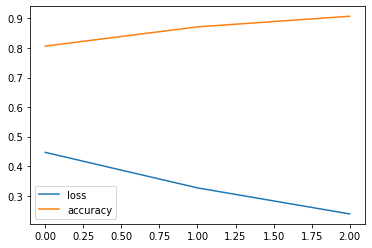

In [ ]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['accuracy'],label='accuracy')
plt.legend()

# Implementation without bert

In [ ]:
#architecture

i=Input(shape=(T,))
x=Embedding(vocab_size+1,embedding_dim,weights=[embedding_matrix], trainable=False)(i)
x=Bidirectional(LSTM(128,return_sequences=True))(x)
x=GlobalMaxPooling1D()(x)
x=Dense(64,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(1,activation='sigmoid')(x)

model=Model(i,x)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 27, 100)           1621000   
_________________________________________________________________
bidirectional (Bidirectional (None, 27, 256)           234496    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_38 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [ ]:


r=model.fit(x_pad,y_train,validation_split=0.2,epochs=10)



Epoch 1/10
191/191 [==============================] - 2s 11ms/step - loss: 0.4778 - accuracy: 0.7844 - val_loss: 0.4296 - val_accuracy: 0.8116
Epoch 2/10
191/191 [==============================] - 1s 8ms/step - loss: 0.4234 - accuracy: 0.8182 - val_loss: 0.4173 - val_accuracy: 0.8116
Epoch 3/10
191/191 [==============================] - 1s 8ms/step - loss: 0.3909 - accuracy: 0.8342 - val_loss: 0.4209 - val_accuracy: 0.8175
Epoch 4/10
191/191 [==============================] - 1s 8ms/step - loss: 0.3567 - accuracy: 0.8534 - val_loss: 0.4168 - val_accuracy: 0.8175
Epoch 5/10
191/191 [==============================] - 1s 8ms/step - loss: 0.3135 - accuracy: 0.8704 - val_loss: 0.4413 - val_accuracy: 0.8089
Epoch 6/10
191/191 [==============================] - 1s 8ms/step - loss: 0.2656 - accuracy: 0.8974 - val_loss: 0.4410 - val_accuracy: 0.8070
Epoch 7/10
191/191 [==============================] - 1s 8ms/step - loss: 0.2226 - accuracy: 0.9184 - val_loss: 0.4836 - val_accuracy: 0.8162
Epoch

In [ ]:
x_pad.shape

(7613, 27)

In [ ]:
x_test=df1.iloc[:,3].values

tokenizer.fit_on_texts(x_test)
test_sequence=tokenizer.texts_to_sequences(x_test)

length=max([i+1 for x in x_test for i in range(len(x.split()))])

AttributeError: ignored

In [ ]:
df1.head()

In [ ]:
test_pad=pad_sequences(test_sequence,maxlen=27,padding='post')


In [ ]:
test_pad.shape

In [ ]:
ex=test_pad[0].reshape(1,-1)

In [ ]:
test_pad[:3]

NameError: ignored

In [ ]:
x_data=next(iter(train_dataset.batch(1)))

In [ ]:
x_data

((<tf.Tensor: shape=(1, 16, 30), dtype=int32, numpy=
  array([[[  101,  2204,  2126,  2203,  2154, 16216, 23274,  2099,  4606,
            6497,  4040,   102,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0],
          [  101,  7861,  5017,  5634,  2270,  3789,  2279,  3296,  2352,
            7071,  2215, 18301,  4894,  4517,  4926, 23713,  2203,  5091,
             102,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0],
          [  101,  2273,  4019,  2482, 24692,  7311, 11968,  3051,  1055,
            8399, 10604, 11538,  3426,   102,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0],
          [  101,  1049,  2232,  2948, 11385,  2179,  2474, 10301,  4394,
            6027,  7608,   102,     0,     0,     0,     0,     0,     0,
               0,     0,     0,   

In [ ]:
for i,elem in enumerate(x_data):
  if i==0:
    train_val=elem
  if i==1:
    train_mask=elem


In [ ]:
tf_data=tf.data.Dataset.from_tensor_slices((train_val,train_mask))

In [ ]:
next(iter(tf_data))

((<tf.Tensor: shape=(16, 30), dtype=int32, numpy=
  array([[  101,  2204,  2126,  2203,  2154, 16216, 23274,  2099,  4606,
           6497,  4040,   102,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0],
         [  101,  7861,  5017,  5634,  2270,  3789,  2279,  3296,  2352,
           7071,  2215, 18301,  4894,  4517,  4926, 23713,  2203,  5091,
            102,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0],
         [  101,  2273,  4019,  2482, 24692,  7311, 11968,  3051,  1055,
           8399, 10604, 11538,  3426,   102,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0],
         [  101,  1049,  2232,  2948, 11385,  2179,  2474, 10301,  4394,
           6027,  7608,   102,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,

In [ ]:
x_pad.shape,test_pad.shape

In [ ]:
x_data=x_data([])

In [ ]:
pred=bert_model.predict(tf_data)


In [ ]:
pred[0].argmax(-1)

array([1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0])

In [ ]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['accuracy'],label='accuracy')
plt.legend()

In [ ]:
y_pred

In [ ]:
test_pad[0]

In [ ]:
y_test[1]